# Optimizing Smoothing Techniques
There are many smoothing techniques available (such as the Exponential Weighted Moving Average) that can be applied to a data set. Finding the optimal smoothness is the objective of this notebook.

## 1. Criteria for measuring "goodness" of smoothness

There are a couple characteristics to a good smoother:

1. Maximize Noise Reduction

- Minimal number of inflection points
- Minimize std deviation

2. Maximize Information Considered

- Window length
- Minimal Decay (If using weights)
- Segment Length


3. Maximize Trend Capture - It should beresponsive to the start of new trends

- Minimal Delay
- Accurate detection of local min and maxima


## 2. Create Mock Data and Apply Smoothing Techniques
First we will create some random data and calculate some moving averages for the data. We will use a random walk to generate data on which we can apply some smoothing techniques.

In [1]:
import numpy
import pandas
import matplotlib.pyplot as pyplot

c:\program files\python\python 3.8\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


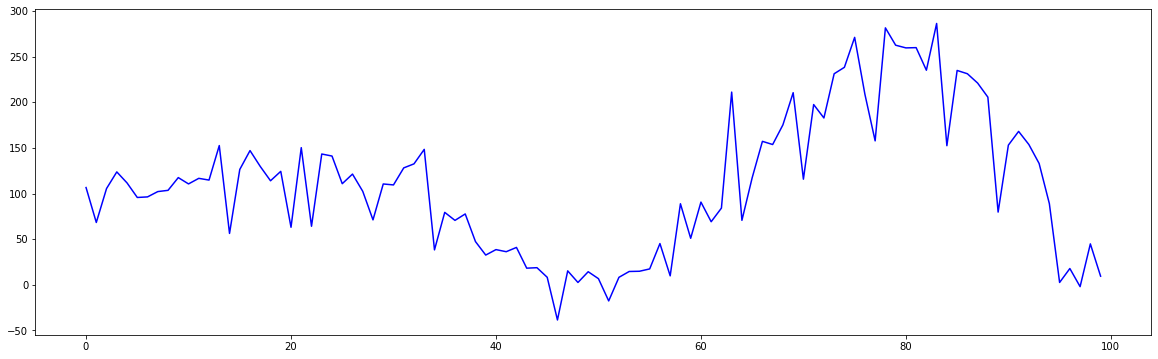

In [2]:
# Seed the random number generator
numpy.random.seed(1147)

# Generate x values
raw = pandas.DataFrame({
    'x': pandas.Series(list(range(0, 100)))
})

# Generate Y trend
raw['y'] = raw['x'] * numpy.sin(0.1 * raw['x']) + 50

# Add Noise
for x in range(0, raw.shape[0]):
    mu = raw['y'].iloc[x]
    mod = numpy.random.randint(1, 50)
    sigma =  mod * numpy.sin(x) + mod
    noise = numpy.random.normal(mu, sigma) + numpy.random.randint(-10, 10)
    raw['y'].iloc[x] = raw['y'].iloc[x] + noise

# Plot the data
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.plot(raw["x"], raw["y"], color="blue")

In [3]:
# Calculate 10 day aveverages
df = raw.copy()
window = 10
df['sma'] = df['y'].rolling(window).mean()

for alpha in [x / 10 for x in range(1, 10)]:
    df['ewma-{0}'.format(alpha)] = df['y'].rolling(window).apply(lambda x: x.ewm(alpha=alpha).mean().iloc[-1])

Text(0.5, 1.0, 'Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

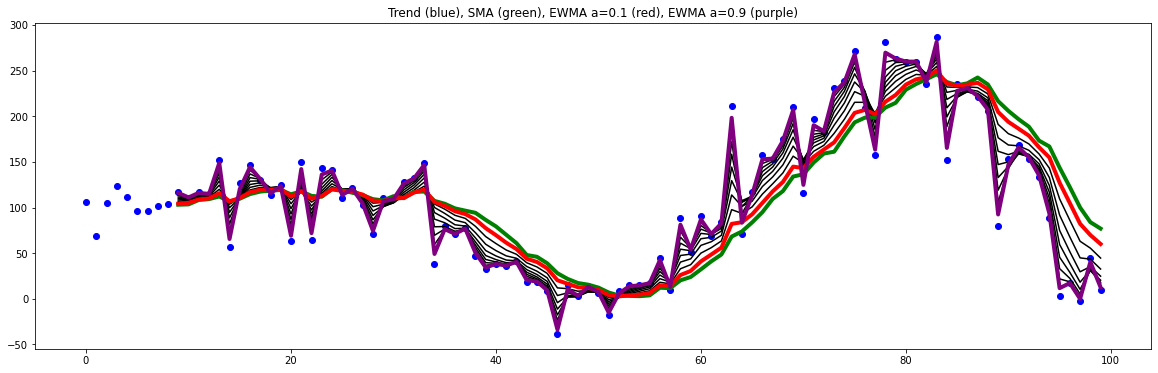

In [4]:
# Plot the data
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(df["x"], df["y"], color="blue")

for alpha in [x / 10 for x in range(1, 10)]:
    ewma_column_name = 'ewma-{0}'.format(alpha)
    axis.plot(df["x"], df[ewma_column_name], color="black")

axis.plot(df["x"], df["sma"], color="green", linewidth=4)
axis.plot(df["x"], df['ewma-0.1'], color="red", linewidth=4)
axis.plot(df["x"], df['ewma-0.9'], color="purple", linewidth=4)
axis.set_title('Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

## 3. Implimentation of the Criteria

### 3.1. Maximize Noise Reduction

- Minimal number of inflection points
- Minimize std deviation

#### 3.1.1 Minimize Number of Inflection Points

Inflection points are the "kinks" or "bends" in the curve generated by the smooth line. We want these to be minimized because the inflection points are directly correlated to the noise.

In [5]:
ewma_column_name = 'ewma-0.1'
tmp = df[['x','y',ewma_column_name]].copy()

def ip(column):
    
    midpoint = int(column.shape[0] / 2)
    
    x0 = column.iloc[midpoint - 1]
    x1 = column.iloc[midpoint]
    x2 = column.iloc[midpoint + 1]
       
    if any([numpy.isnan(x0), numpy.isnan(x1), numpy.isnan(x2)]):
        value = False
    
    if x0 < x1 > x2:
        value = True
    
    elif x0 > x1 < x2:
        value = True
    else:
        value = False
    
    return value

tmp["{0}_ip".format(ewma_column_name)] = tmp[ewma_column_name].rolling(window, center=True).apply(ip)

tmp.head()

,x,y,ewma-0.1,ewma-0.1_ip
0,0,106.518989,NaN,NaN
1,1,68.272043,NaN,NaN
2,2,105.446863,NaN,NaN
3,3,123.656907,NaN,NaN
4,4,111.579356,NaN,NaN


Text(0.5, 1.0, 'Smooth Line (green) Inflection Points (red)')

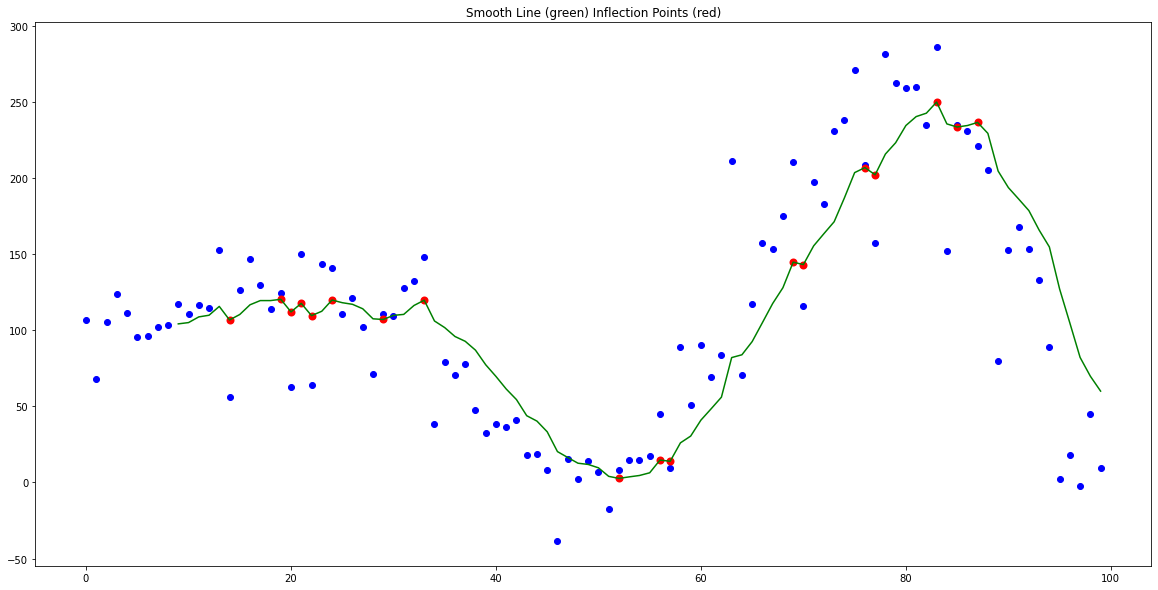

In [6]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 10))
axis.scatter(df["x"], df["y"], color="blue")
axis.plot(tmp["x"], tmp[ewma_column_name], color="green")
axis.scatter(tmp["x"], tmp[ewma_column_name].where(tmp["{0}_ip".format(ewma_column_name)] == 1), color="red", linewidth=2)
axis.set_title('Smooth Line (green) Inflection Points (red)')

We can create a score to measure the number of inflection points identified by the smooth line

In [7]:
def ip_score(df, window, column_name, smooth_column_name):
    tmp = df.copy()
    
    tmp["{0}_ip".format(column_name)] = tmp[column_name].rolling(window, center=True).apply(ip)  
    tmp["{0}_ip".format(smooth_column_name)] = tmp[smooth_column_name].rolling(window, center=True).apply(ip)  

    b = tmp.loc[tmp["{0}_ip".format(column_name)] == 1].shape[0]
    a = tmp.loc[tmp["{0}_ip".format(smooth_column_name)] == 1].shape[0]
    
    return a / b
    
score = ip_score(tmp, window, 'y', ewma_column_name)
print("score: {0}".format(score))

score: 0.29508196721311475


### 3.1.2. Minimize Std Deviation
Noise contributes to standard deviation. The smaller the standard deviation the less noise. We will measure standard deviation based on a rolling window.

We will measure the standard deviation of the smooth line compared to the standard deviation of the raw data for each window. We will then take the average of that value.

In [8]:
ewma_column_name = 'ewma-0.1'
tmp = df[['x','y',ewma_column_name]].copy()
tmp["{0}_std".format(ewma_column_name)] = tmp[ewma_column_name].rolling(window, center=True).std()
tmp["y_std".format(ewma_column_name)] = tmp['y'].rolling(window, center=True).std()
tmp.iloc[40:50]

,x,y,ewma-0.1,ewma-0.1_std,y_std
40,40,38.543059,69.672954,22.010812,22.574033
41,41,36.248908,61.416011,22.521339,22.104907
42,42,40.932941,54.467312,23.868725,30.184953
43,43,18.209922,43.875504,23.732813,24.749802
44,44,18.733327,40.316995,22.624522,23.632957
45,45,8.219193,33.300311,20.991758,23.017465
46,46,-38.536077,20.276470,18.909872,21.627309
47,47,15.255449,16.437403,17.079849,21.702127
48,48,2.548866,12.651075,14.735328,18.175872
49,49,14.303922,11.838761,12.688379,17.885625


Text(0.5, 1.0, 'Stadnard Deviation (red)')

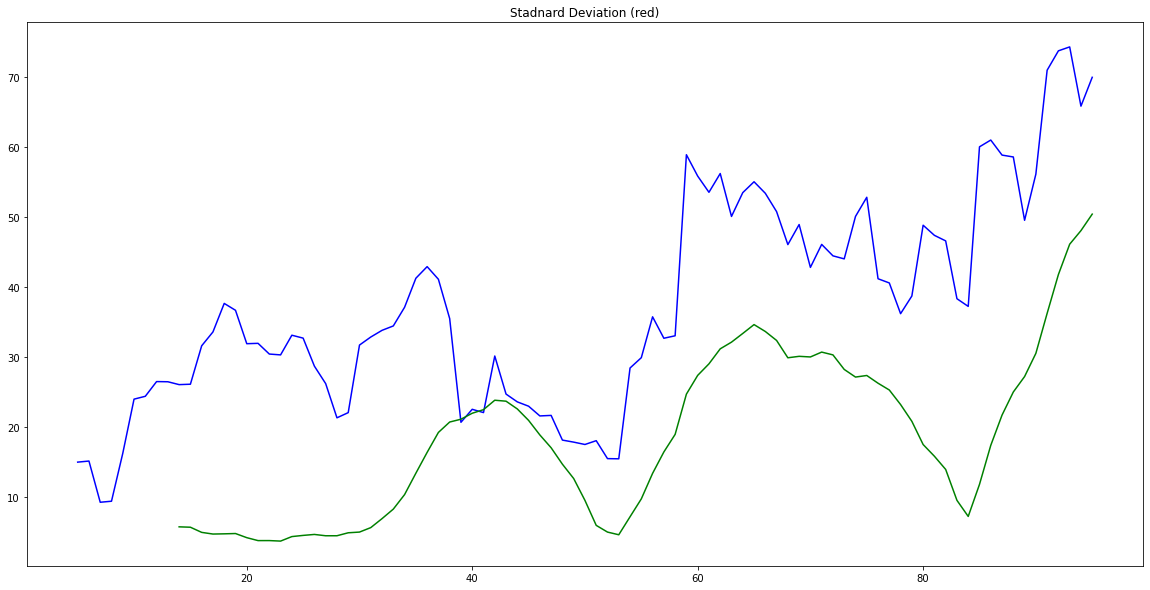

In [9]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 10))
axis.plot(tmp["x"], tmp["y_std".format(ewma_column_name)], color="blue")
axis.plot(tmp["x"], tmp["{0}_std".format(ewma_column_name)], color="green")
axis.set_title('Stadnard Deviation (red)')

We can create a score to create a measurement of the proportion of noise in our smooth line vs the noise in our data. Like the other scores, we want a value closer to one to be interpreted as "better". As such, this will be a meausrement of noise reduction.

In [10]:
def std_score(df, window, column_name, smooth_column_name):
    tmp = df.copy()
    
    tmp["{0}_std".format(column_name)] = tmp[column_name].rolling(window, center=True).std()
    tmp["{0}_std".format(smooth_column_name)] = tmp[smooth_column_name].rolling(window, center=True).std()

    a = tmp["{0}_std".format(smooth_column_name)].sum()
    b = tmp["{0}_std".format(column_name)].sum()    

    frac = a / b
    score = 1 - frac
    return score

score = std_score(df, window, 'y', ewma_column_name)
score

0.5511571186464094

### 3.2. Maximize Information Considered

 - Maximal Window length
 - Minimal Decay (If using weights)
 - Maximal Segment Length


#### 3.2.1. Maximal Window Length
The longer the window, the more information that feeds into the smoothing technique. We want to reward the techniques being applied to longer windows.

We will simply use the window length as the score, the smaller the score the better. We might also consider a square of the score.

In [11]:
def window_score(df, window, column_name, smooth_column_name):
    return window / df.shape[0]

#### 3.2.2. Minimal Decay
If we are using a weight or a decay it means that the terms in a series will be disproportionally impacting the smoothing technique. In a vaccuum we want to avoid using weights because they make the model more susseptable to outliers and leverage points.

If we plot our erights as a regression, the slope of the regression will indicate ??

#### 3.2.3 Maximal Segment Length

The purpose of a smoothing technique is to segment noise from signal, random behavior from underlying trends. The smooth line that is produced by a smoothing technique can me thought of as a sequence of updard and downward trends. In a vaccuum, a smooth line would be less reactive to short term spikes in the underlying data resulting in fewer segments and longer segment lengths.

This is the opposite side of the coin to inflection points. We do not need a new measurement here.

### 3.3. Maximize Trend Characteristic Capture

 - Minimal Delay and Goodness of Fit
 - Mirror Local Maximum and Minimums
 - Mirror Local Extremes
 - Signal to Noise Ratio?

#### 3.3.1. Goodness of Fit

In [12]:
def r2_score(df, window, column_name, smooth_column_name):
    tmp = df.copy()
    
    y = tmp[column_name]
    y_bar = y.mean()
    
    SST = ((y - y_bar)**2).sum()
    
    y_hat = tmp[smooth_column_name]

    SSE = ((y - y_hat)**2).sum()
    
    
    return 1 - (SSE / SST)
    
score = r2_score(df, window, 'y', ewma_column_name)
print("score: {0}".format(score))

score: 0.7291617052961428


#### 3.3.2 Mirror Local Minima and Maxima

An important characteristic of a smoothing technique is its ability to remove noise in order to track the underlying trend. This can be a double edged sword because the in some cases the extreme terms may indicate regime changes. Specifically the local minima and maxima.

We want out smooth line to mirror the local minima and maxima.


In [13]:
def local_min_max(column):
    
    # First we must determine the index of the mid point
    index = int(column.shape[0]/2)
    
    # Then we must check if that midpoint is a min or max for the window    
    mid_point = column.iloc[index]
    column_min = column.min()
    column_max = column.max()
    
    if mid_point == column_max or mid_point == column_min:
        return True
    else:
        return False

ewma_column_name = 'ewma-0.1'
tmp = df[['x','y',ewma_column_name]].copy()


tmp["y_lm"] = tmp['y'].rolling(10, center=True).apply(local_min_max)
tmp["{0}_lm".format(ewma_column_name)] = tmp[ewma_column_name].rolling(10, center=True).apply(local_min_max)


a = tmp["{0}_lm".format(ewma_column_name)] == True
b = tmp["y_lm"] == True
tmp[ a | b].head()

,x,y,ewma-0.1,y_lm,ewma-0.1_lm
13,13,152.507399,115.702105,1.0,NaN
14,14,56.277535,106.799120,1.0,0.0
19,19,124.274224,120.374414,0.0,1.0
20,20,63.008633,112.095562,1.0,0.0
21,21,150.218332,117.707215,1.0,0.0


Text(0.5, 1.0, 'Inflection Points and Local Extrema')

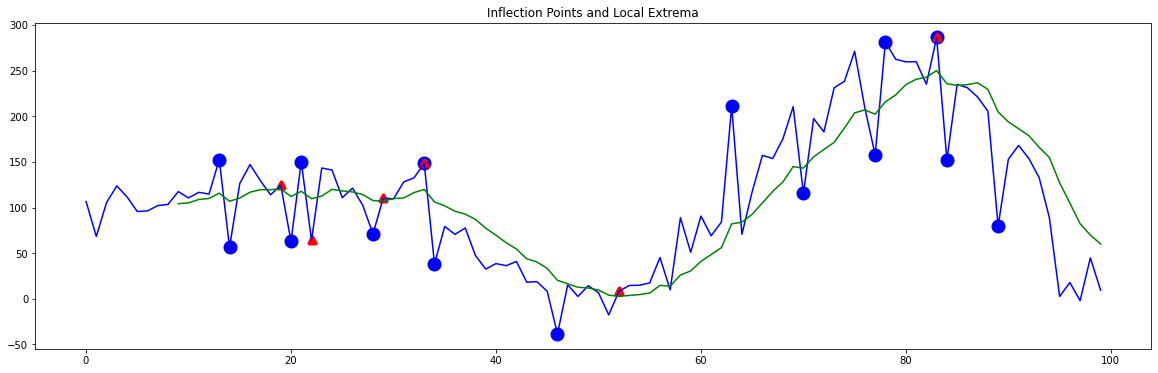

In [14]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.plot(df["x"], df["y"], color="blue")
axis.plot(tmp["x"], tmp[ewma_column_name], color="green")

x = tmp['x'].loc[tmp["{0}_lm".format('y')] == True]
y = tmp['y'].loc[tmp["{0}_lm".format('y')] == True]
axis.scatter(x, y, color="blue", linewidth=8)

x = tmp['x'].loc[tmp["{0}_lm".format(ewma_column_name)] == True]
y = tmp['y'].loc[tmp["{0}_lm".format(ewma_column_name)] == True]
axis.scatter(x, y, color="red", marker='^', linewidth=4)

axis.set_title('Inflection Points and Local Extrema')

We can create a standard score to measure the number of local min/max that were detected by the algorithm.

In [15]:
def local_min_max_score(df, window, column_name, smooth_column_name):
    tmp = df.copy()

    # Apply the functions
    tmp["{0}_lm".format(column_name)] = tmp[column_name].rolling(window, center=True).apply(local_min_max)
    tmp["{0}_lm".format(smooth_column_name)] = tmp[smooth_column_name].rolling(window, center=True).apply(local_min_max)

    # Calculate the number of local minima/maxima that were detected
    a1 = tmp["{0}_lm".format(column_name)] == True
    a2 = tmp["{0}_lm".format(smooth_column_name)] == True
    
    a = tmp.loc[a1 & a2].shape[0]
    b = tmp.loc[tmp["{0}_lm".format(column_name)] == True].shape[0]

    score = a/b
    return score

score = local_min_max_score(df, window, 'y', ewma_column_name)
score

0.13333333333333333

#### 3.3.2. Mirror Local Extremes

An important characteristic of a smoothing technique is its ability to remove noise in order to track the underlying trend. This can be a double edged sword because the in some cases the extreme terms may indicate regime changes. Specifically the local minima and maxima.

There are extremes and outliers and we want our smoothing technique to allow the data scientist to decide what they want to keep.

If the local extremes of a smooth line match the local extremes of raw data, the model is accurately tracking the trend.

In [16]:
def local_extreme(column):
    
    # First we must determine the index of the mid point
    index = int(column.shape[0]/2)
    
    # Then we must check if that midpoint is a min or max for the window    
    mid_point = column.iloc[index]
    mean = column.mean()
    std = column.std()
    upper_bound = mean + std
    lower_bound = mean - std
        
    extreme = False
    if mid_point > upper_bound or mid_point < lower_bound:
        extreme = True
    
        #print(lower_bound, mid_point, upper_bound, extreme)
    
    return extreme

ewma_column_name = 'ewma-0.1'
tmp = df[['x','y',ewma_column_name]].copy()


tmp["y_lm"] = tmp['y'].rolling(10, center=True).apply(local_extreme)
tmp["{0}_lm".format(ewma_column_name)] = tmp[ewma_column_name].rolling(10, center=True).apply(local_extreme)


tmp.head()

,x,y,ewma-0.1,y_lm,ewma-0.1_lm
0,0,106.518989,NaN,NaN,NaN
1,1,68.272043,NaN,NaN,NaN
2,2,105.446863,NaN,NaN,NaN
3,3,123.656907,NaN,NaN,NaN
4,4,111.579356,NaN,NaN,NaN


Text(0.5, 1.0, 'Inflection Points and Local Extrema')

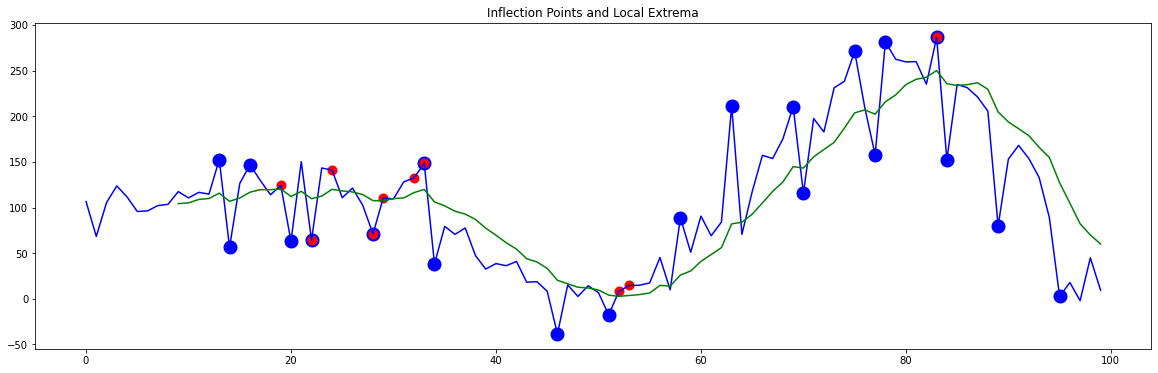

In [17]:
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.plot(df["x"], df["y"], color="blue")
axis.plot(tmp["x"], tmp[ewma_column_name], color="green")

axis.scatter(tmp["x"], tmp['y'].where(tmp["y_lm"] == 1), color="blue", linewidth=8)
axis.scatter(tmp["x"], tmp['y'].where(tmp["{0}_lm".format(ewma_column_name)] == 1), color="red", linewidth=4)

axis.set_title('Inflection Points and Local Extrema')

In [18]:
def local_extreme_score(df, window, column_name, smooth_column_name):
    tmp = df.copy()

    # Apply the functions
    tmp["{0}_lm".format(column_name)] = tmp[column_name].rolling(window, center=True).apply(local_extreme)
    tmp["{0}_lm".format(smooth_column_name)] = tmp[smooth_column_name].rolling(window, center=True).apply(local_extreme)

    # Calculate the number of local minima/maxima that were detected
    a1 = tmp["{0}_lm".format(column_name)] == True
    a2 = tmp["{0}_lm".format(smooth_column_name)] == True
    
    a = tmp.loc[a1 & a2].shape[0]
    b = tmp.loc[tmp["{0}_lm".format(column_name)] == True].shape[0]
    
    score = a/b
    return score

score = local_extreme_score(tmp, window, 'y', ewma_column_name)
print("score: {0}".format(score))

score: 0.19047619047619047


# 4. Combining scores into one new score
We want to consider all these scores, optimizing the good ones and minimizing the bad ones. First lets have a look at the scores.

In [19]:
# Determine what scores we are interested in
score_names = [
    "ip_score",
    "std_score",
    "window_score",
    "local_min_max_score",
    "local_extreme_score",
    "r2_score"
]

# Determine the columns
columns = list(df.columns)
columns.remove('x')
columns.remove('y')


# Create the dataframe to hold our data
scores = pandas.DataFrame({}, index=score_names, columns=columns)

# Generate alphas
alphas = [x / 10 for x in range(1, 10)]

# Set the window
window = 10

# Calculate the smooth lines
df['sma'] = df['y'].rolling(window).mean()
alphas = [x / 10 for x in range(1, 10)]
for alpha in alphas:
    df['ewma-{0}'.format(alpha)] = df['y'].rolling(window).apply(lambda x: x.ewm(alpha=alpha).mean().iloc[-1])
    
# Loop through the smooth lines and calculate scores
for smooth_column_name in list(scores.columns):    
    column_name = 'y'    
    for score_name in score_names:
        score = eval(score_name)(df, window, column_name, smooth_column_name)
        scores[smooth_column_name][score_name] = score
        
scores

,sma,ewma-0.1,ewma-0.2,ewma-0.3,ewma-0.4,ewma-0.5,ewma-0.6,ewma-0.7,ewma-0.8,ewma-0.9
ip_score,0.262295,0.295082,0.42623,0.491803,0.52459,0.622951,0.655738,0.688525,0.754098,0.770492
std_score,0.570399,0.551157,0.51908,0.476656,0.427497,0.37449,0.318574,0.259374,0.195818,0.126403
window_score,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
local_min_max_score,0.133333,0.133333,0.2,0.333333,0.333333,0.4,0.6,0.666667,0.666667,0.8
local_extreme_score,0.190476,0.190476,0.333333,0.380952,0.52381,0.619048,0.666667,0.714286,0.809524,0.857143
r2_score,0.648118,0.729162,0.799949,0.85583,0.897625,0.929005,0.953322,0.972436,0.98692,0.996458


Text(0.5, 1.0, 'Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

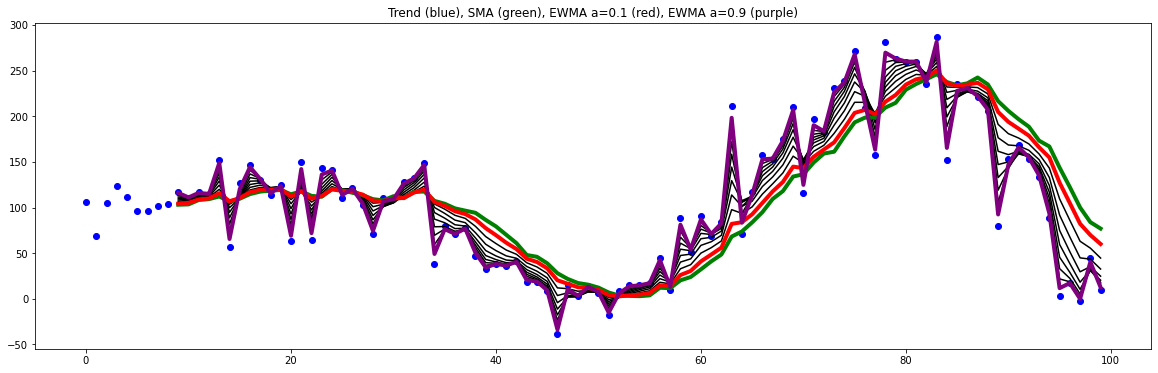

In [20]:
# Plot the data
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(df["x"], df["y"], color="blue")

for alpha in [x / 10 for x in range(1, 10)]:
    ewma_column_name = 'ewma-{0}'.format(alpha)
    axis.plot(df["x"], df[ewma_column_name], color="black")

axis.plot(df["x"], df["sma"], color="green", linewidth=4)
axis.plot(df["x"], df['ewma-0.1'], color="red", linewidth=4)
axis.plot(df["x"], df['ewma-0.9'], color="purple", linewidth=4)
axis.set_title('Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

Lets have a look at what a weighted sum of the scores would look like. We need certain scores to be counter balanced.

In [50]:
def smooth_score(df, window, column_name, smooth_column_name):
    
    smooth_score_names = [
        "std_score"
    ]
    
    fit_score_names = [
        "ip_score",
        "window_score",
#        "local_min_max_score",
        "local_extreme_score",
        "r2_score"
    ]    
    smooth_scores = []
    for score_name in smooth_score_names:
        score = eval(score_name)(df, window, column_name, smooth_column_name)
        weight = 1 / len(smooth_score_names)
        smooth_scores.append(score * weight)

    fit_scores = []
    for score_name in fit_score_names:
        score = eval(score_name)(df, window, column_name, smooth_column_name)
        weight = 1 / len(fit_score_names)
        fit_scores.append(score * weight)
    
    a = sum(smooth_scores)
    b = sum(fit_scores)    
    score =  a + b 
    #print(smooth_column_name, a, b, score)
    return score
    
# Create the dataframe to hold our data
scores = pandas.DataFrame({}, columns=columns)

# Loop through the smooth lines and calculate scores
for smooth_column_name in list(scores.columns):    
    column_name = 'y'    
    score = smooth_score(df, window, column_name, smooth_column_name)
    scores.at[0, smooth_column_name] = score
        
scores

,sma,ewma-0.1,ewma-0.2,ewma-0.3,ewma-0.4,ewma-0.5,ewma-0.6,ewma-0.7,ewma-0.8,ewma-0.9
0,1.02987,1.03554,1.08818,1.0591,1.02986,1.01081,0.971665,0.92011,0.859951,0.816069


## 5. Optimization of Criteria

### 4.1. Optimization in two dimensions
We will setup a new dataframe to hold our results

In [48]:
# Set hyperparameters to optimize
alphas = [x / 10 for x in range(1, 10)]
windows = range(3, 15)

# Set functions to call
smooth_technique_names = ["sma"] + ["ewma-{0}".format(alpha) for alpha in alphas]
smooth_technique_names

['sma',
 'ewma-0.1',
 'ewma-0.2',
 'ewma-0.3',
 'ewma-0.4',
 'ewma-0.5',
 'ewma-0.6',
 'ewma-0.7',
 'ewma-0.8',
 'ewma-0.9']

In [54]:
def smooth(df, column, technique, window):
    tmp = df.copy()
    if technique == "sma":
        tmp[technique] = tmp[column].rolling(window).mean()
    elif technique.split("-")[0] == "ewma":
        alpha = technique.split("-")[1]
        alpha = float(alpha)
        tmp[technique] = tmp[column].rolling(window).apply(lambda x: x.ewm(alpha=alpha).mean().iloc[-1])
        
    return tmp

# Create the dataframe to hold our smooth data and scores
smooths = raw.copy()
scores = pandas.DataFrame({}, columns=columns)

for window in windows:
    for smooth_technique in smooth_technique_names:
        # Calc smooth
        tmp = smooth(smooths,'y',smooth_technique, window)
        
        # calc score
        score = smooth_score(df, window, 'y', smooth_technique)
        
        # store score in df
        scores.at[window, smooth_technique] = score

scores

,sma,ewma-0.1,ewma-0.2,ewma-0.3,ewma-0.4,ewma-0.5,ewma-0.6,ewma-0.7,ewma-0.8,ewma-0.9
3,1.02987,1.03554,1.08818,1.0591,1.02986,1.01081,0.971665,0.92011,0.859951,0.816069
4,1.00793,1.01995,1.06969,1.07317,1.09416,1.07547,1.01017,0.979118,0.928777,0.848917
5,0.985415,1.00756,1.04687,1.05269,1.07683,1.05148,1.00223,0.941525,0.873384,0.813872
6,0.966427,0.986118,1.03375,1.07116,1.04502,1.02094,0.974533,0.91492,0.864316,0.809542
7,0.935404,0.963627,0.998177,0.990408,1.00152,0.969866,0.936485,0.881937,0.845573,0.783954
8,0.904922,0.9363,0.986409,0.993444,1.00296,0.986706,0.937563,0.906249,0.854638,0.799136
9,0.893718,0.925525,0.965833,0.963597,0.953342,0.95239,0.918643,0.880134,0.844219,0.788843
10,0.870621,0.879837,0.933958,0.933802,0.939004,0.942241,0.912506,0.878185,0.858453,0.807426
11,0.888705,0.885959,0.940958,0.930256,0.925645,0.919939,0.905252,0.862501,0.834716,0.795272
12,0.870059,0.855283,0.899125,0.88954,0.886502,0.906991,0.882959,0.843161,0.818827,0.770994


Text(0.5, 1.0, 'Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

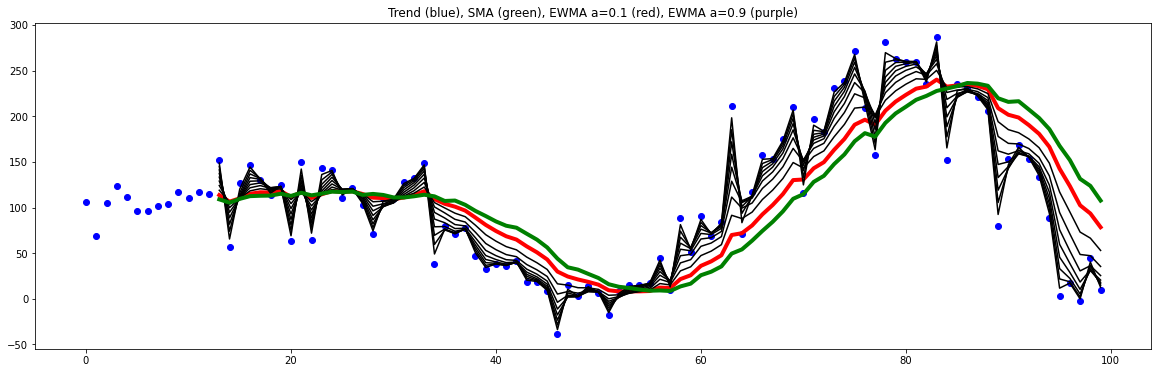

In [56]:
# Plot the data
figure, axis = pyplot.subplots(nrows=1,ncols=1,figsize=(20, 6))
axis.scatter(df["x"], df["y"], color="blue")

# Plot the ewmas
windows = 5
for alpha in [x / 10 for x in range(1, 10)]:
    smooth_technique = "ewma-{0}".format(alpha)
    tmp = smooth(df,'y',smooth_technique, window)
    if smooth_technique == 'ewma-0.1':
        axis.plot(tmp["x"], tmp[smooth_technique], color="red", linewidth=4)
    elif smooth_technique == 'ewma-0.1':
        axis.plot(tmp["x"], tmp[smooth_technique], color="purple", linewidth=4)
    else:
        axis.plot(tmp["x"], tmp[smooth_technique], color="black")

# Plot the sma
tmp = smooth(df,'y',"sma", window)
axis.plot(tmp["x"], tmp["sma"], color="green", linewidth=4)

# Set the title
axis.set_title('Trend (blue), SMA (green), EWMA a=0.1 (red), EWMA a=0.9 (purple)')

We can see that the larger window results in a less optimal smoothness.